In [1]:
from mae.encoder import *
from mae.decoder import *
from dataset import *
import gin

In [2]:
gin.parse_config_file("config/encoder_config1.gin")
encoder_config = EncoderConfig()

gin.parse_config_file("config/decoder_config1.gin")
decoder_config = DecoderConfig()
# decoder_config.do_loss_calculation = False

In [3]:
decoder_config

DecoderConfig(image_size=128, in_proj_dim=256, hidden_size=256, intermediate_size=768, num_hidden_layers=4, num_attention_heads=2, num_channels=3, patch_size=8, norm_eps=1e-08, attention_dropout=0.0, do_loss_calculation=True, use_small_mlp=True, num_image_tokens=256, head_dim=128, patched_image_height=16, patched_image_width=16, rng_seed=42, rng_generator=<torch._C.Generator object at 0x00000208577257F0>)

In [4]:
encoder = EncoderModel(encoder_config)
decoder = DecoderModel(decoder_config)

In [5]:
# img, class_name = next(iter(train_dataloader))
# img.shape, class_name

# sample input 
img = torch.randn(1, 3, 128, 128)

In [6]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

In [7]:
decoder_op[0].shape, img.shape

(torch.Size([1, 3, 128, 128]), torch.Size([1, 3, 128, 128]))

In [8]:
decoder_op[1]

tensor(1.4485, grad_fn=<DivBackward0>)

In [49]:
loss = masked_pixel_loss(decoder_op[0], img, mask)
loss

tensor(17772.4160, grad_fn=<SumBackward0>)

In [ ]:
def expand_mask(mask, img_size=128, patch_size=8):
    """
    Expands a patch-level mask (batch_size, num_patches) into an image-level mask (batch_size, 1, H, W)
    """
    batch_size, num_patches = mask.shape
    grid_size = img_size // patch_size  # Number of patches along one dimension (128/8 = 16)

    # Reshape from (batch_size, num_patches) -> (batch_size, 1, grid_size, grid_size)
    mask = mask.view(batch_size, 1, grid_size, grid_size)

    # Upscale mask to image resolution (batch_size, 1, height, width)
    mask = F.interpolate(mask.float(), scale_factor=patch_size, mode="nearest")
    return mask  # Shape: (batch_size, 1, 128, 128)

def masked_pixel_loss(x_rec, x, mask):
    """
    Computes loss only on masked patches in the spatial domain.
    
    Args:
        x_rec: Reconstructed image tensor of shape (batch_size, channel, height, width)
        x: Original image tensor of shape (batch_size, channel, height, width)
        mask: Binary mask tensor of shape (batch_size, num_patches)
    
    Returns:
        Masked MSE loss
    """
    assert x_rec.shape == x.shape
    mask_expanded = expand_mask(mask, img_size=128, patch_size=8)  # Shape (batch_size, 1, 128, 128)
    
    loss = F.mse_loss(x_rec, x, reduction="none")  # Compute pixel-wise loss (batch_size, 3, 128, 128)
    loss = loss.mean(dim=1, keepdim=True)  # Average over channels → (batch_size, 1, 128, 128)

    masked_loss = (loss * mask_expanded).sum() / mask_expanded.sum()  # Compute loss only for masked areas
    return masked_loss

In [29]:
mse_loss = nn.MSELoss(reduction="mean")
mse_loss(img, decoder_op[0])/img.shape[0]

tensor(1.4606, grad_fn=<DivBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7081645..2.711673].


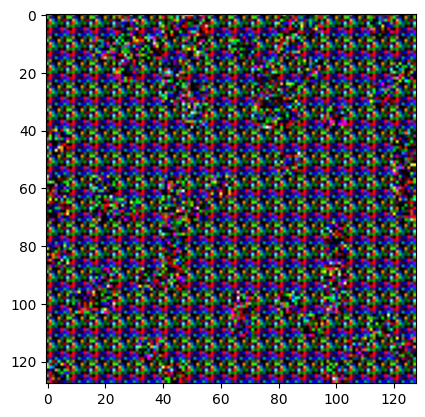

In [8]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));

In [9]:
from dataset import *

In [10]:
import os
files = os.listdir("dataset")
ds = Birddataset("dataset/", allowed_classes=files, dataset_type="train", do_transform=True)

In [11]:
train_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "train")
test_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "test")

In [12]:
train_dataset.__len__()
test_dataset.__len__()

12

In [13]:
train_dataset.__getitem__(0)

(tensor([[[-0.6623, -0.5424, -0.5938,  ...,  0.6221,  0.9132,  0.9132],
          [-0.7650, -0.5596, -0.5767,  ...,  0.7762,  0.8961,  0.7077],
          [-0.5596, -0.4054, -0.4226,  ...,  0.8789,  0.9474,  0.7933],
          ...,
          [-1.6898, -1.5357, -1.3302,  ..., -0.6452, -1.9295, -1.9980],
          [-1.6898, -1.7583, -1.8097,  ..., -0.9192,  2.2489,  0.0569],
          [-2.1179, -1.4672, -1.4672,  ...,  0.8789, -0.9020,  0.2796]],
 
         [[-0.9503, -0.8277, -0.8627,  ...,  0.4853,  0.7829,  0.7829],
          [-1.0553, -0.8277, -0.8452,  ...,  0.6429,  0.7654,  0.5728],
          [-0.8277, -0.6702, -0.6877,  ...,  0.7829,  0.8529,  0.6954],
          ...,
          [-1.4755, -1.3529, -1.1779,  ..., -1.3529, -1.7556, -1.3704],
          [-1.2654, -1.4755, -1.8782,  ..., -1.3179,  1.7283, -0.5826],
          [-1.7731, -1.1604, -1.5980,  ...,  0.6779, -1.8957, -1.0203]],
 
         [[-1.0376, -0.9156, -1.0027,  ..., -0.1487,  0.1476,  0.1476],
          [-1.1421, -0.9678,

In [14]:
from model import *
# load mae wrapper config
# gin.parse_config_file("config/wrapper_config1.gin")
wrapper_config = MAEWrapperConfig()

In [15]:
wrapper_config

MAEWrapperConfig(lr=0.0003, batch_size=4, num_epochs=10, weight_decay=0.0001, eps=1e-08, seed=42, betas=(0.9, 0.999), gpu_count=1, device='cuda')